<h1> Read and Categorize the Discord Messages </h1>

Each user request for image generation is encoded as a [Message](https://discord.com/developers/docs/resources/channel#message-object) object.

In [1]:
import json
import os

filepaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))
print(f"Found {len(filepaths)} files.")

Found 272 files.


As illustrated in the dataset description, users interact with the MidJourney bot in three ways:

1. Issue a new text prompt (with an optional image prompt) to request image generation.
2. Request variations of a previously generated image.
3. Request upscaling a previously generated image.

The majority of messages reflect one of these three intents. Here we ignore all other messages (e.g. text messages simply saying hello).

In [2]:
from collections import defaultdict
import glob
import json

# Detect the message type based on the UI components shown to the user.
# See https://discord.com/developers/docs/interactions/message-components#what-is-a-component
COMPONENTS_FOR_INITIAL_AND_VARIATION = set(
    ['U1', 'U2', 'U3', 'U4', '⟳', 'V1', 'V2', 'V3', 'V4'])
COMPONENTS_FOR_UPSCALE = set(
    ['Make Variations', 'Upscale to Max', 'Light Upscale Redo'])


def get_message_type(message):
  """Figures out the message type based on the UI components displayed."""
  for components in message["components"]:
    for component in components["components"]:
      if component["label"] in COMPONENTS_FOR_INITIAL_AND_VARIATION:
        # For (very few) messages that are supposedly initial or variation requests, the content indicates
        # that they are actually upscale requests. We will just put these aside.
        if "Upscaled" in message["content"]:
          return "INCONCLUSIVE"
        return "INITIAL_OR_VARIATION"
      elif component["label"] in COMPONENTS_FOR_UPSCALE:
        return "UPSCALE"
  return "TEXT_MESSAGE"

messages_by_type = defaultdict(list)
for filepath in filepaths:
  with open(filepath, "r") as f:
    content = json.load(f)
    for single_message_list in content["messages"]:
      assert len(single_message_list) == 1
      message = single_message_list[0]
      message_type = get_message_type(message)
      messages_by_type[message_type].append(message)
        
print("Message counts:")
for mtype, messages in messages_by_type.items():
  print("\t", mtype, len(messages))

Message counts:
	 INITIAL_OR_VARIATION 145822
	 UPSCALE 102249
	 TEXT_MESSAGE 20309
	 INCONCLUSIVE 43


<h1> Explore User-Generated Prompts </h1>

In [3]:
import re

def get_prompt(message):
    """Extracts the prompt from the message content, which is located between double stars."""
    content = message["content"]
    # Replace newlines with spaces; makes the regex below work.
    content = content.replace("\n", " ")
    # Find the text enclosed by two consecutive stars.
    BETWEEN_STARS = "\\*\\*(.*?)\\*\\*"
    match = re.search(BETWEEN_STARS, content)
    if match:
        return match.group()[2:-2]  # Exclude the stars.
    

def remove_urls(prompt):
    """Prompts can include both text and images; this method removes the prompt image URLs."""
    URL = "<https[^<]*>?\s"
    matches = re.findall(URL, prompt)
    for match in matches:
        prompt = prompt.replace(match, "")
    return prompt
    

def get_generated_image_url(message):
    """Extracts the URL of the generated image from the message."""
    attachments = message["attachments"]
    if len(attachments) == 1:
        return attachments[0]["url"]

Going forward, we will focus on INITIAL_OR_VARIATION prompts, since the UPSCALE prompts are a subset of the former (an UPSCALE request is associated with the same prompt used to generate the image that is currently being upscaled).

In [4]:
from dataclasses import dataclass

@dataclass
class UserRequest:
    prompt: str
    generated_url: str

user_requests = []
for m in messages_by_type["INITIAL_OR_VARIATION"]:
    prompt = get_prompt(m)
    generated_url = get_generated_image_url(m)
    # In *very* rare cases, messages are malformed and these fields cannot be extracted.
    if prompt and generated_url:
        user_requests.append(UserRequest(prompt, generated_url))
        
num_messages = len(messages_by_type["INITIAL_OR_VARIATION"])
print(f"Parsed {len(user_requests)} user requests from {num_messages} messages.")

Parsed 145080 user requests from 145822 messages.


Let's see how many of these requests include an image in the prompt.

In [5]:
total = len(user_requests)
with_url = sum([0 if remove_urls(r.prompt) == r.prompt else 1 for r in user_requests])
print(f"{with_url} out of {total} INITIAL_AND_VARIATION prompts include an image")

70694 out of 145080 INITIAL_AND_VARIATION prompts include an image


In [6]:
import pandas as pd

pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

pd.DataFrame({"User Prompt": [r.prompt for r in user_requests],
              "Generated Image URL": [r.generated_url for r in user_requests]})

,User Prompt,Generated Image URL
0,"a human standing next to his ship, looking down at an abandoned alien City, octane render",https://cdn.discordapp.com/attachments/990909803066974238/991855558716035142/59eb679e-b8ba-4c82-83f6-cc4810b4e57a_TrajicK_aka_ToxicHustle_-_CSO_a_human_standing_next_to_his_ship_looking_down_at_an_abandoned_alien_City_octane_render.png
1,"jisoo 金智秀Kim Ji-soo 김지수 キム・ジス,epic painting of beautiful angelic women , painting by jc leyendecker, jason chan,Krenz Cushart, Yoneyama Mai Mucha, stunning atmosphere, light effects, A woman with black princess cut hairstyle wearing a kimono, a traditional Japanese costume. She is next to a lakeside deep in the forest..,gold blue jewlery, marvel, face artgerm, fairy, tempel, calm breeze, Rendered in Octane, trending in artstation, cgsociety, Charlie Bowater and Gabrielle Ragusi, highly detailed, harmonic lighting, symmetrical, cinematic lighting, intricate details, cinematic 8k, hyperealistic, octane render, photo realism,realistic face, Realistic material,Biopark,high detail,by Greg Rutkowski, Fenghua Zhong, Jordan Grimmer, Huang Guangjian, artstation, pete morbacher, hyper detailed, very detailed, artstation, rendering by octane, unreal engine, Trending on pixiv, artstation artists --ar 2:3",https://cdn.discordapp.com/attachments/991229985174073365/991855547815055400/5cabbe00-cb95-45ff-b576-6f73d96a19e7__jisoo_Kim_Ji-soo__epic_painting_of_beautiful_angelic_women__painting_by_jc_leyendecker_jas.png
2,"jisoo 金智秀Kim Ji-soo 김지수 キム・ジス,epic painting of beautiful angelic women , painting by jc leyendecker, jason chan,Krenz Cushart, Yoneyama Mai Mucha, Violet evergarden, trending pixiv, stunning atmosphere, light effects, A woman with black princess cut hairstyle wearing a kimono, a traditional Japanese costume. She is next to a lakeside deep in the forest..,gold blue jewlery, marvel, face artgerm, fairy, tempel, calm breeze, Rendered in Octane, trending in artstation, cgsociety, Charlie Bowater and Gabrielle Ragusi, highly detailed, harmonic lighting, symmetrical, cinematic lighting, intricate details, cinematic 8k, hyperealistic, octane render, photo realism,realistic face, Realistic material,Biopark,high detail,by Greg Rutkowski, Fenghua Zhong, Jordan Grimmer, Huang Guangjian, artstation, pete morbacher, hyper detailed, very detailed, artstation, rendering by octane, unreal engine, Trending on pixiv, artstation artists --ar 2:3",https://cdn.discordapp.com/attachments/991229985174073365/991855482027388969/f4092f70-e806-47ab-97eb-2594665e971a__jisoo_Kim_Ji-soo__epic_painting_of_beautiful_angelic_women__painting_by_jc_leyendecker_jas.png
3,"a human standing next to his ship, looking down at an abandoned alien City",https://cdn.discordapp.com/attachments/990909803066974238/991855132771876966/eec42821-3c7a-46ac-adf1-ddd263d35fca_TrajicK_aka_ToxicHustle_-_CSO_a_human_standing_next_to_his_ship_looking_down_at_an_abandoned_alien_City.png
4,"Bridget Regan with brown hair, happy, oil painting, portrait, intricate complexity, rule of thirds, face by Artgerm, character concept, dramatic lighting, Complementary colors",https://cdn.discordapp.com/attachments/991504828750630963/991855024885997579/7a08fea7-94b9-4eb3-a151-d281eb9c42b3_MattE_Bridget_Regan_with_brown_hair_happy_oil_painting_portrait_intricate_complexity_rule_of_thirds_face_b.png
...,...,...
145075,"<https://s.mj.run/HqS0fo6C6WQ> cat with many eyes floating in colorful glowing swirling whisps, occult inspired, emerging from the void, shallow depth of field",https://cdn.discordapp.com/attachments/982990243621908480/988957965493092392/f32d458d-9120-409d-824d-adab5c95a7b6_MissTwistedRose_cat_with_many_eyes_floating_in_colorful_glowing_swirling_whisps_occult_inspired_emerging_from_the_vo.png
145076,"isometric 3d DMT Replications Mandelbrot, octane render, Trending on artstation, intricate complexity, --ar 16:9",https://cdn.discordapp.com/attachments/981545067779088384/988957897251782706/61bfbddf-aa69-442f-8b26-dec067cfb470_Mark

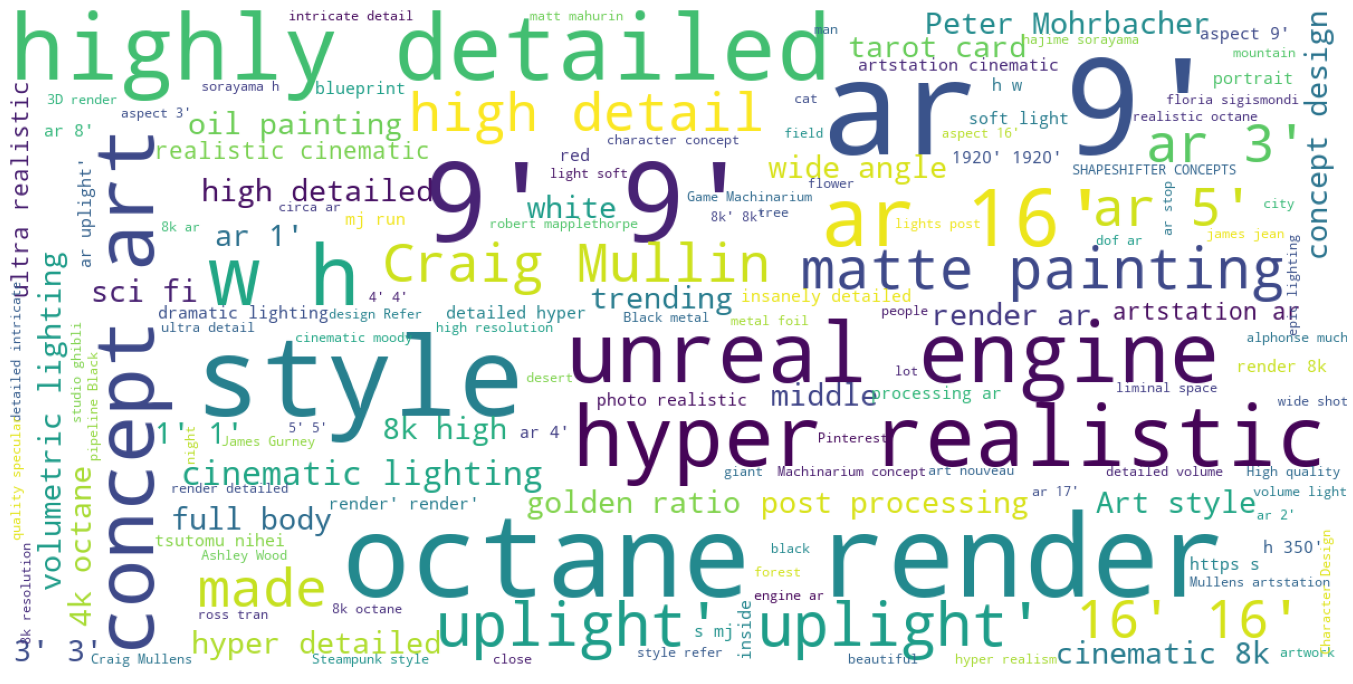

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(24, 24))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

prompts_wo_urls = [remove_urls(r.prompt) for r in user_requests]
show_wordcloud(prompts_wo_urls)

<h2> Prompt Lengths </h2>

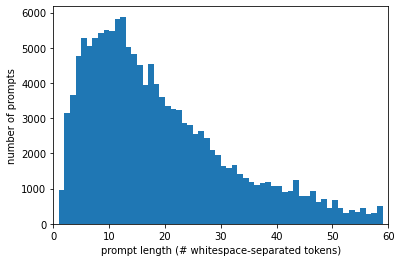

In [8]:
import matplotlib.pyplot as plt

# MidJourney truncates the input prompts at ~60 tokens.
MAX_TOKENS = 60

axes = plt.gca()
axes.set_xlim([0, MAX_TOKENS])
axes.set_xlabel("prompt length (# whitespace-separated tokens)")
axes.set_ylabel("number of prompts")

# Filter out VARIATION requests that prompt the model via image, with no text description.
requests_with_text = [r for r in user_requests if not (r.prompt.startswith("<https://") and r.prompt.endswith(">"))]
lengths = [len(r.prompt.split(" ")) for r in requests_with_text]

plt.hist(lengths, bins=range(MAX_TOKENS));

<h2> Prompts to Control the Light </h2>

In [9]:
def count_prompts_with_tag(prompts, tag):
  return sum([1 if tag.lower() in p.lower() else 0 for p in prompts])

def bar_plot(count_dict, rotation=45):
  keys_values = sorted(count_dict.items(), key=lambda xy: xy[1], reverse=True)
  keys, values = zip(*keys_values)
  plt.xticks(rotation=rotation)
  plt.bar(range(len(count_dict)), values, tick_label=keys)
  plt.show()

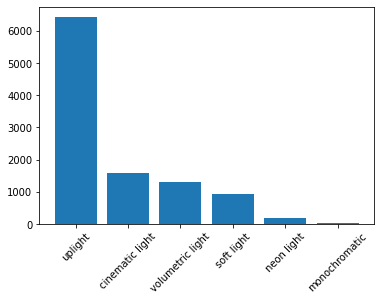

In [10]:
LIGHT_TAGS = ["monochromatic", "uplight", "neon light", "soft light", "cinematic light", "volumetric light"]
light_tag_counts = {tag: count_prompts_with_tag(prompts_wo_urls, tag) for tag in LIGHT_TAGS}
bar_plot(light_tag_counts) 

<h2> Prompts to Control the Resolution </h2>

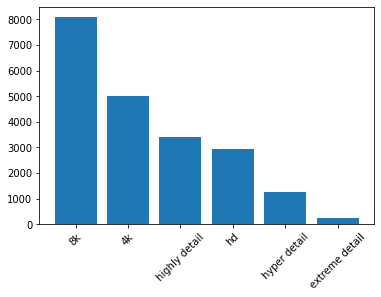

In [11]:
# Note that people also specify "h XXX", "hXXX", "w YYY", "wYYY", and combinations of width and height.
RESOLUTION_TAGS = ["hd", "4k", "8k", "extreme detail", "highly detail", "hyper detail"]
resolution_tags = {tag: count_prompts_with_tag(prompts_wo_urls, tag) for tag in RESOLUTION_TAGS}
bar_plot(resolution_tags)

<h2> Prompts Related to Photography </h2>

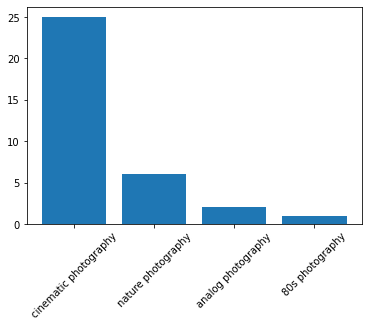

In [12]:
PHOTOGRAPHY_TAGS = ["analog photography", "nature photography", "80s photography", "cinematic photography"]
photo_tags = {tag: count_prompts_with_tag(prompts_wo_urls, tag) for tag in PHOTOGRAPHY_TAGS}
bar_plot(photo_tags)

<h2> Prompts for Art Style </h2>

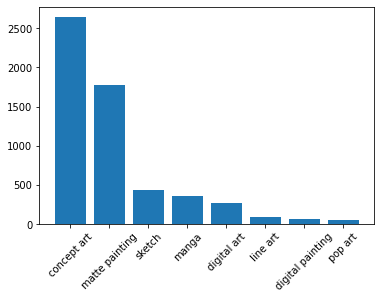

In [13]:
RENDER_TAGS = ["concept art", "digital art", "digital painting", "sketch", "matte painting", "pop art", "line art", "manga"]
render_tags = {tag: count_prompts_with_tag(prompts_wo_urls, tag) for tag in RENDER_TAGS}
bar_plot(render_tags)

<h2> Artist Mentions </h2>

In [14]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

def find_people(text):
  doc = nlp(text)
  return [x.text for x in doc.ents if x.label_ == "PERSON"]

# Since tagging is expensive, we'll randomly select 10k prompts.
import random
random.shuffle(prompts_wo_urls)

people = []
for i, prompt in enumerate(prompts_wo_urls[:10000]):
    if i % 1000 == 0:
        print(f"Processed {i} prompts")
    people.extend(find_people(prompt))

Processed 0 prompts
Processed 1000 prompts
Processed 2000 prompts
Processed 3000 prompts
Processed 4000 prompts
Processed 5000 prompts
Processed 6000 prompts
Processed 7000 prompts
Processed 8000 prompts
Processed 9000 prompts


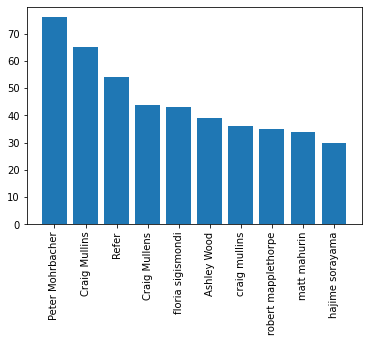

In [15]:
bar_plot(dict(Counter(people).most_common(10)), rotation=90)